In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score


Load dataset from Kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arturbiedermann","key":"676b796f9d96fe21d54ad8a6a9d999b0"}'}

In [3]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

  0% 0.00/50.1k [00:00<?, ?B/s]
100% 50.1k/50.1k [00:00<00:00, 30.0MB/s]


In [5]:
!unzip ibm-hr-analytics-attrition-dataset.zip

Archive:  ibm-hr-analytics-attrition-dataset.zip
  inflating: WA_Fn-UseC_-HR-Employee-Attrition.csv  


In [6]:
attrition = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [7]:
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


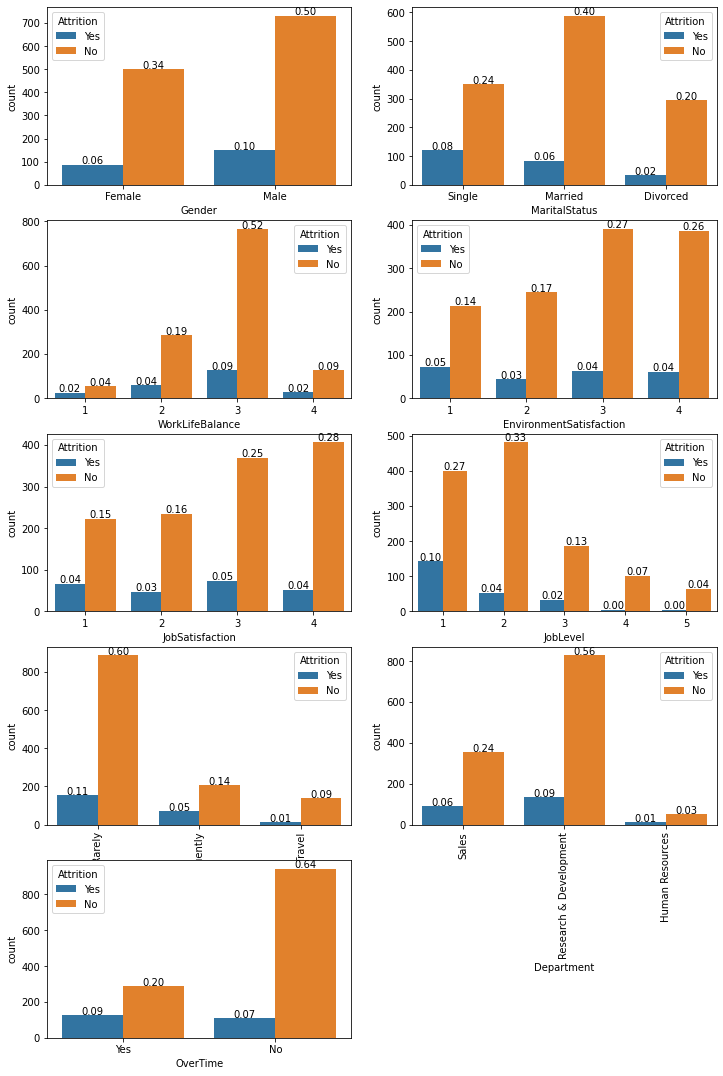

In [8]:
#Distribution of attrition values by columns
total_records= len(attrition)
columns = ["Gender","MaritalStatus","WorkLifeBalance","EnvironmentSatisfaction","JobSatisfaction",
           "JobLevel","BusinessTravel","Department","OverTime"]
plt.figure(figsize=(12,8))
j=0
for i in columns:
    j +=1
    plt.subplot(8,2,j)
    ax1 = sns.countplot(data=attrition,x=i,hue="Attrition")
    if(j==8 or j== 7):
        plt.xticks( rotation=90)
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/total_records,0),
                ha="center",rotation=0) 

# Custom the subplot layout
plt.subplots_adjust(bottom=-0.9, top=2)
plt.show()

In [9]:
#Attrition of people by age
age_att=attrition.groupby(['Age','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
px.line(age_att,x='Age',y='Counts',color='Attrition',title='Agewise Counts of People in an Organization')

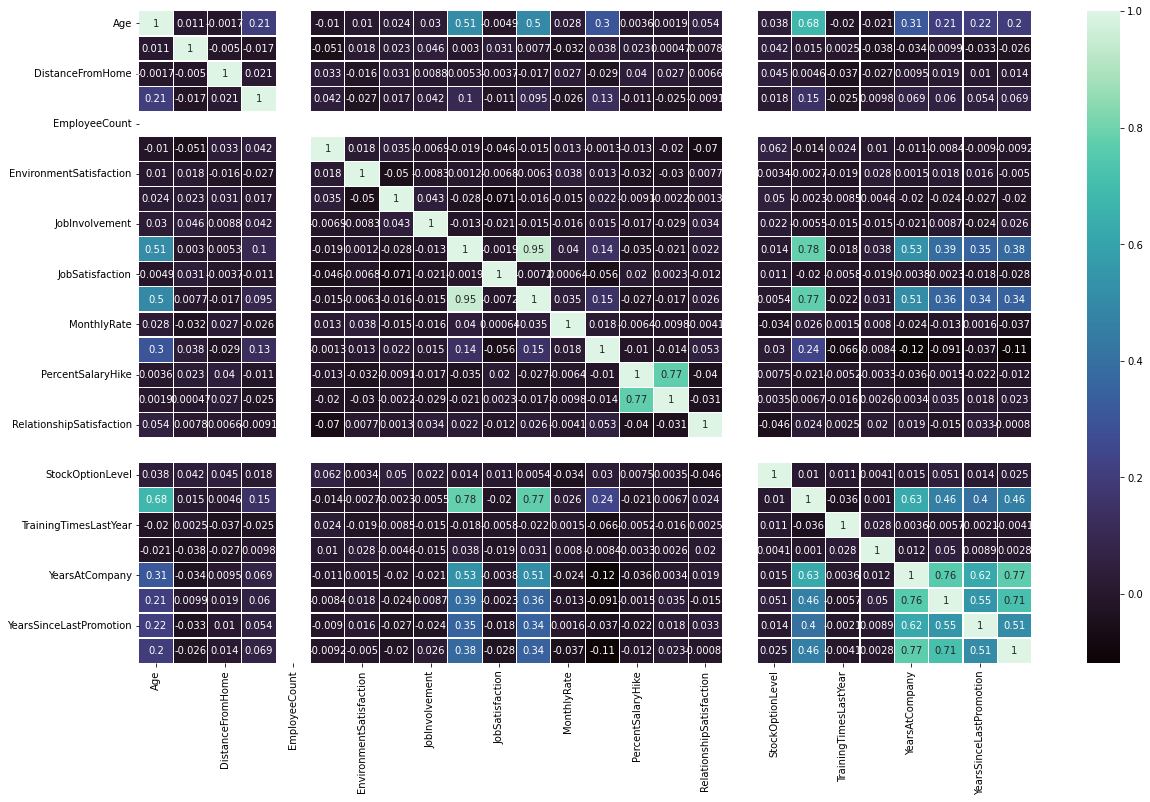

In [10]:
#Correlation between columns
sns.heatmap(attrition.corr(),annot=True,cmap='mako',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [13]:
#Checking highly correlated columns
def corr_threshold(corr, threshold = 0.65):

    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    corr_th = corr.stack()[corr.stack().abs() > threshold]
    return(corr_th)

In [14]:
threshold = 0.7
corr = attrition.corr()
corr_th = corr_threshold(corr, threshold)
corr_th

MonthlyIncome         JobLevel              0.950300
PerformanceRating     PercentSalaryHike     0.773550
TotalWorkingYears     JobLevel              0.782208
                      MonthlyIncome         0.772893
YearsInCurrentRole    YearsAtCompany        0.758754
YearsWithCurrManager  YearsAtCompany        0.769212
                      YearsInCurrentRole    0.714365
dtype: float64

In [15]:
#Replace object columns by numbers

In [16]:
attrition['Attrition'].replace({"Yes":1,"No":0},inplace=True)

In [17]:
attrition['Gender'].replace({"Male":1,"Female":0},inplace=True)

In [18]:
attrition['OverTime'].replace({"Yes":1,"No":0},inplace=True)

In [19]:
attrition = pd.get_dummies(attrition, columns= ['Department','BusinessTravel','EducationField','JobRole','MaritalStatus'],drop_first= True)

In [20]:
attrition.isnull().sum()

Age                                  0
Attrition                            0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EmployeeCount                        0
EmployeeNumber                       0
EnvironmentSatisfaction              0
Gender                               0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
JobSatisfaction                      0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
Over18                               0
OverTime                             0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StandardHours                        0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
WorkLifeBalance          

In [21]:
attrition.dtypes

Age                                   int64
Attrition                             int64
DailyRate                             int64
DistanceFromHome                      int64
Education                             int64
EmployeeCount                         int64
EmployeeNumber                        int64
EnvironmentSatisfaction               int64
Gender                                int64
HourlyRate                            int64
JobInvolvement                        int64
JobLevel                              int64
JobSatisfaction                       int64
MonthlyIncome                         int64
MonthlyRate                           int64
NumCompaniesWorked                    int64
Over18                               object
OverTime                              int64
PercentSalaryHike                     int64
PerformanceRating                     int64
RelationshipSatisfaction              int64
StandardHours                         int64
StockOptionLevel                

In [23]:
#Check values several columns
attrition['Over18'].value_counts()

Y    1470
Name: Over18, dtype: int64

In [24]:
attrition['EmployeeCount'].value_counts()

1    1470
Name: EmployeeCount, dtype: int64

In [25]:
attrition['StandardHours'].value_counts()

80    1470
Name: StandardHours, dtype: int64

In [26]:
attrition['EmployeeNumber'].value_counts

<bound method IndexOpsMixin.value_counts of 0          1
1          2
2          4
3          5
4          7
        ... 
1465    2061
1466    2062
1467    2064
1468    2065
1469    2068
Name: EmployeeNumber, Length: 1470, dtype: int64>

In [27]:
#Drop the columns with one value and EmployeeNumber which is just ID
attrition.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

In [28]:
attrition.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [29]:
attrition.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,802.485714,9.192517,2.912925,2.721769,0.600000,65.891156,2.729932,2.063946,...,0.035374,0.176190,0.069388,0.098639,0.054422,0.198639,0.221769,0.056463,0.457823,0.319728
std,9.135373,0.367863,403.509100,8.106864,1.024165,1.093082,0.490065,20.329428,0.711561,1.106940,...,0.184786,0.381112,0.254199,0.298279,0.226925,0.399112,0.415578,0.230891,0.498387,0.466530
min,18.000000,0.000000,102.000000,1.000000,1.000000,1.000000,0.000000,30.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,465.000000,2.000000,2.000000,2.000000,0.000000,48.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,0.000000,802.000000,7.000000,3.000000,3.000000,1.000000,66.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,43.000000,0.000000,1157.000000,14.000000,4.000000,4.000000,1.000000,83.750000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,60.000000,1.000000,1499.000000,29.000000,5.000000,4.000000,1.000000,100.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
#DROPPING HIGH CORRELETAD
attrition.drop(['MonthlyIncome', 'PerformanceRating', 'TotalWorkingYears', 'YearsInCurrentRole','YearsWithCurrManager'], axis="columns", inplace=True)

In [31]:
attrition.nunique()

Age                                    43
Attrition                               2
DailyRate                             886
DistanceFromHome                       29
Education                               5
EnvironmentSatisfaction                 4
Gender                                  2
HourlyRate                             71
JobInvolvement                          4
JobLevel                                5
JobSatisfaction                         4
MonthlyRate                          1427
NumCompaniesWorked                     10
OverTime                                2
PercentSalaryHike                      15
RelationshipSatisfaction                4
StockOptionLevel                        4
TrainingTimesLastYear                   7
WorkLifeBalance                         4
YearsAtCompany                         37
YearsSinceLastPromotion                16
Department_Research & Development       2
Department_Sales                        2
BusinessTravel_Travel_Frequently  

In [34]:
#Split the dataset to test and train
x = attrition.drop('Attrition', axis=1)
y = attrition.Attrition

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 0)

In [35]:
#Use StandardScaler
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [36]:
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
acc_logreg= accuracy_score(y_test, Y_pred)
print('LogisticRegression: %', 100 * acc_logreg)

LogisticRegression: % 87.41496598639455


In [37]:
# Support Vector Machines
SVC()
svc = SVC()
svc.fit(x_train, y_train)
Y_pred = svc.predict(x_test)
acc_svc= accuracy_score(y_test, Y_pred)
print('Accuracy SVC: %', 100 * acc_svc)

Accuracy SVC: % 86.05442176870748


In [38]:
# k-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
Y_pred = knn.predict(x_test)
acc_knn= accuracy_score(y_test, Y_pred)
print('Accuracy k-Nearest Neighbors: %', 100 * acc_knn)

Accuracy k-Nearest Neighbors: % 83.33333333333334


In [39]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=10).fit(x_train, y_train)
predictions_rf = rf.predict(x_test)
acc_rf = accuracy_score(y_test, predictions_rf)
print('Accuracy Random Forest: %', 100 * acc_rf)

Accuracy Random Forest: % 85.37414965986395


In [40]:
dt_clf = DecisionTreeClassifier().fit(x_train, y_train)
preditions_dt_clf = dt_clf.predict(x_test)
acc_dt_clf = accuracy_score(y_test, preditions_dt_clf)
print('Accuracy DecisionTreeClassifier: %', 100 * acc_dt_clf)

Accuracy DecisionTreeClassifier: % 79.59183673469387


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [56]:
logreg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [57]:
#Using GridSearchCV to find the best params
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(svc,parameters, cv=3,n_jobs=-1)
grid.fit(x_train, y_train)
print("Accuracy:",grid.best_score_)

Accuracy: 0.8826530612244898


In [58]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)


              precision    recall  f1-score   support

           0       0.89      0.97      0.93       245
           1       0.75      0.43      0.55        49

    accuracy                           0.88       294
   macro avg       0.82      0.70      0.74       294
weighted avg       0.87      0.88      0.87       294



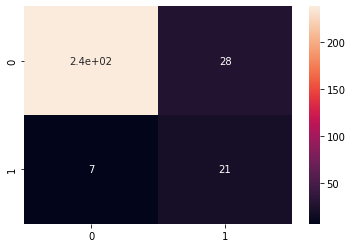

In [67]:
grid_predictions = grid.predict(x_test)

#Confusion matrix
sns.heatmap(confusion_matrix(grid.predict(x_test), y_test),annot=True)  
# print classification report
cm = classification_report(y_test, grid_predictions)
print(cm)